In [1]:
library(dplyr)
library(magrittr)
library(data.table)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [2]:
library(Seurat)

In [3]:
dge_background = readRDS("/Users/LoboM/Dropbox/shared_Bioinformatics/scrna_objects/10x_pharynx/whole_atlas_filtered.Robj")

In [4]:
dge_background %<>% UpdateSeuratObject

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version



In [6]:
foxn1_ko_act = read.csv("/Users/LoboM/Dropbox/scRNA_data_analysis/pharynx_analysis3/results/preprocess_explore_10x/foxn1_ko/2020_Apr_13__17_30_19__foxn1_ko_isolate_via_classifier/user/foxn1_ko_diff_expr.csv",stringsAsFactors = F, row.names = 1)

In [8]:
dge_background

An object of class Seurat 
27998 features across 54044 samples within 1 assay 
Active assay: RNA (27998 features, 1119 variable features)
 3 dimensional reductions calculated: pca, tsne, umap

In [9]:
thymic_cells = colnames(dge_background %>% subset(ident = c(4, 9, 25)))

In [10]:
length(thymic_cells)

[1] 5544

- read simulated data

In [44]:
sim_path = '/Users/LoboM/Dropbox/FINAL_CO/Foxn1_delta_sim_filtered_top_in_source_0005.csv'

In [45]:
sim_fc = read.csv(sim_path,stringsAsFactors = F, row.names = 1)

- label predicted direct targets ( up = red ) ( down = blue )
- take separate spearmann correlation

In [14]:
for (entry in colnames(sim_fc)){
    if ('Nkx2.1' == entry){
        print(entry)
    }
}

[1] "Nkx2.1"


In [15]:
# foxn1_ko_act
for (entry in rownames(foxn1_ko_act)){
    if ('Nkx2.1' == entry){
        print(entry)
    }
}

[1] "Nkx2.1"


- subset to thymic cells

In [46]:
simulated_thymic_fc = colMeans(sim_fc[thymic_cells, ])

In [47]:
simulated_thymic_fc = data.frame(simulated_thymic_fc)

In [48]:
simulated_thymic_fc$gene = rownames(simulated_thymic_fc)

In [49]:
simulated_thymic_fc$gene %<>% as.character

In [50]:
dim(simulated_thymic_fc)

[1] 10000     2

In [51]:
dim(foxn1_ko_act)

[1] 13472     6

In [61]:
actual = foxn1_ko_act
sim = simulated_thymic_fc

- susbet to variable genes in roadmap

In [62]:

sim %<>% subset(gene %in% dge_background@assays$RNA@var.features)# Object@assays$RNA@var.features

In [54]:
dim(sim)

[1] 1032    2

In [55]:
dim(actual)

[1] 13472     6

In [63]:

actual %<>% subset(actual$gene %in% dge_background@assays$RNA@var.features)# Object@assays$RNA@var.features

In [57]:
dim(actual)

[1] 1071    6

In [58]:
length(dge_background@assays$RNA@var.features)

[1] 1119

In [59]:
# actual %<>% merge(sim, by = "gene", all.x = T)

In [64]:
sim %<>% merge(actual, by = "gene", all.x = T)

In [65]:
sim_no_foxn1 = sim %>% subset(!gene %in% "Foxn1" )

In [67]:
library(ggplot2)

In [143]:
to_label = c("Prss16", "Psmb11", "Il7", "Pcp4",
             "Tbata", "Gas6",
             "Ccl25", "Cxcl12", "Nkx2.6",
             "Ppp1r16b","Cd83","H2.Ab1","Ly75" ) # margaret added, rest were from eric

In [108]:
sim$simulated_thymic_fc = -sim$simulated_thymic_fc
sim$logFC = -sim$logFC

sim_no_foxn1$simulated_thymic_fc = -sim_no_foxn1$simulated_thymic_fc
sim_no_foxn1$logFC = -sim_no_foxn1$logFC

Warning message:
“Ignoring unknown aesthetics: label”
Warning message:
“Removed 41 rows containing missing values (geom_point).”
Warning message:
“Removed 41 rows containing missing values (geom_point).”


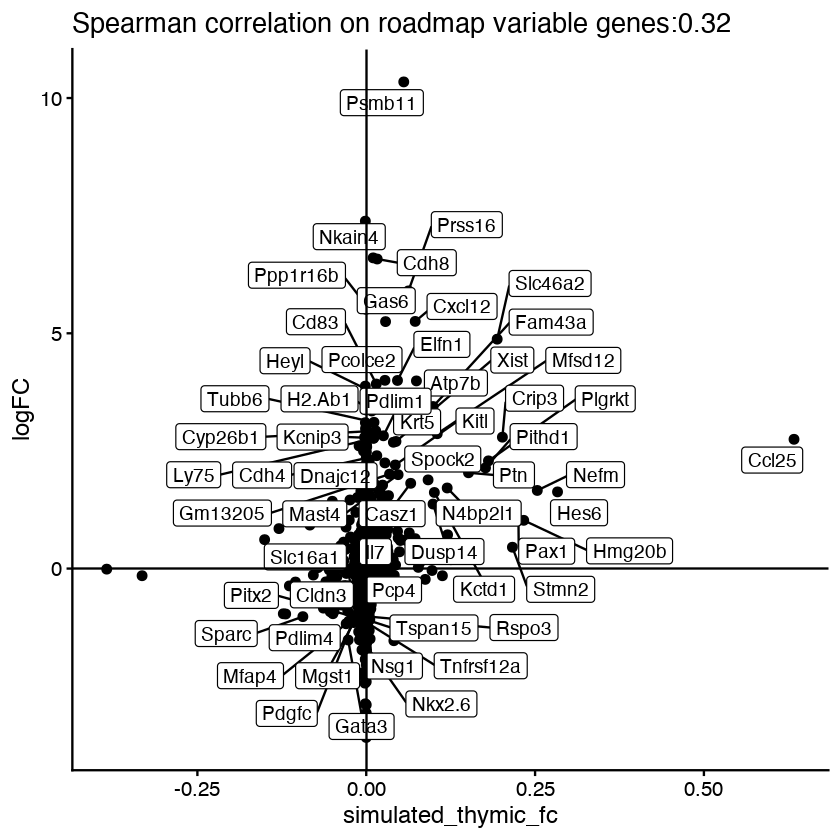

In [152]:
ggplot() +
  ggtitle(
    cor(sim$simulated_thymic_fc, sim$logFC, use = "complete.obs", method = "spearman") %>% 
      round(2) %>%
      paste0("Spearman correlation on roadmap variable genes:", .)
  ) +
  geom_point(      aes(x = simulated_thymic_fc, y = logFC, label = gene), data = sim_no_foxn1,size=2) +
  ggrepel::geom_label_repel(aes(x = simulated_thymic_fc, y = logFC, label = gene),
                   data = sim_no_foxn1 %>% subset(((simulated_thymic_fc > 0.01 & logFC > 1) & (8*simulated_thymic_fc + logFC > 2)) | (simulated_thymic_fc > 0.2) | ((simulated_thymic_fc < -0.01 & logFC < -1)) | gene %in% to_label),max.overlaps=Inf) +
  cowplot::theme_cowplot() + 
  geom_hline(yintercept = 0) + 
  geom_vline(xintercept = 0)
ggsave( "Logfc_sim_vs_real.pdf", width = 8, height = 8)


In [141]:
write.csv(sim_no_foxn1,"actual_vs_simulated.csv")